# Sequential rumour stance prediction

For my 'sequential domain adaptation' project I am looking into classification problems where the training and test samples originate from different distributions. This type of scenario occurs relatively often in settings where data is non-stationary over time. Knowledge of how classifiers may "adapt" to account for differences between underlying distributions is crucial to improving machine learning systems. The main problem in domain adaptation is that the "domains" are often very dissimilar, which means that there is a lot of uncertainty about the adaptation step.

Rumours tend to change over time; people discuss different aspects of the story. We could view this process as a word space distribution that evolves over time. But people sleep. Which means that the word space distribution changes over days. 

## Subspace alignment

In this notebook, I will tackle this problem using a [Subspace Aligned Classifier](https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf).

In [1]:
import numpy as np
import pandas as pd
import pickle as pc
import dateutil
import numpy.random as rnd

# Import feature extractors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer

# Import visualizers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Import classifiers
from sklearn import svm
from sklearn import linear_model
from subalign import SubspaceAlignedClassifier

# Import class imbalance techniques
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set font size
fS = 20

In [3]:
# Experimental parameters
which_rumour = 'charliehebdo'
classifier = 'lr'
kernel = 'rbf'
degree = 2
l2 = 1.0
subspace_dim = 100

In [4]:
# Load data
X = np.load('../data/RumEval2019/rumeval19.npy')
tweets = pd.read_json('../data/RumEval2019/RumEval19.json')

X[np.isnan(X)] = 0

In [5]:
# Show rumours
rumours_ = tweets['rumour'].tolist()
rumours = np.unique(tweets['rumour'].tolist())
[print(rumour) for rumour in rumours];

charliehebdo
ebola-essien
ferguson
germanwings-crash
illary
ottawashooting
prince-toronto
putinmissing
sydneysiege


In [6]:
# Show dates
# dates_ = [dateutil.parser.parse(date).date() for date in tweets['date'].tolist()]
dates_ = [date.date() for date in tweets['date'].tolist()]
dates = np.unique(dates_)

## Sequential prediction over days within 1 rumour

In [7]:
# Subselect rumour 'charliehebdo'
tweets_r = tweets[tweets['rumour'] == which_rumour]

In [8]:
# Subselect embeddings
X = X[(tweets['rumour'] == which_rumour).values, :]

In [9]:
# Map data to bag-of-words format
# tW = TweetTokenizer(strip_handles=True).tokenize
# tV = CountVectorizer(stop_words='english', analyzer='word', tokenizer=tW, strip_accents='unicode', lowercase=True)

# T = np.array(tV.fit_transform(tweets).todense())
# F = np.array(tV.get_feature_names())

In [10]:
# Subselect labels and map to numerical
labels_ = tweets_r['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])

In [11]:
# Subselect dates
dates_ = tweets_r['date'].values
dates = np.unique(tweets_r['date'])

In [12]:
# Classification experiment

# Preallocate performance array
nperf_array = []
aperf_array = []
days_array = []

# Loop over days
for d in range(1, len(dates)-1):

    # Set range up to yesterday
    past = range(d)

    # Create training data from all previous days
    trn_index = tweets_r['date'].isin(dates[past]).values

    # Find all tweets from today
    tst_index = (tweets_r['date'] == dates[d]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Check label proportions
    print('Label shape of train set, before resampling: \t %s' % Counter(trn_Y))
    
    # Set up under-sampling using specified classifier
    trn_X_, trn_Y_ = RandomOverSampler().fit_resample(trn_X, trn_Y)
    
    # Check label proportions
    print('Label shape of train set, after resampling: \t %s' % Counter(trn_Y_))
    
    # Adaptive classifier
    aclf = SubspaceAlignedClassifier(num_components=subspace_dim)
    V, CX, CZ = aclf.subspace_alignment(trn_X, tst_X)
    
    # Define classifier
    if classifier in ('lr', 'logr', 'logistic'):
        
        # Linear logistic model
        nclf = linear_model.LogisticRegression(C=l2, solver='lbfgs')
        aclf = linear_model.LogisticRegression(C=l2, solver='lbfgs')
        
    elif classifier in ('svm', 'svc', 'rbfsvc'):
        
        # Polynomial support vector machine
        nclf = svm.SVC(kernel=kernel, C=l2)
        aclf = svm.SVC(kernel=kernel, C=l2)
        
    else:
        raise ValueError('Classifier not recognized')

    # Train classifier on labeled data from previous days and unlabeled data from today
    nclf.fit(trn_X_, trn_Y_)
    aclf.fit(trn_X_ @ CX @ V, trn_Y_)

    # Make predictions on test set
    npreds = nclf.predict(tst_X)
    apreds = aclf.predict(tst_X @ CZ)

    # Test on data from current day and store
    nperf_array.append(np.mean(npreds == tst_Y))
    aperf_array.append(np.mean(apreds == tst_Y))

# Compact to DataFrame
results = pd.DataFrame({'dates': dates[1:-1],
                        'acc_naive': nperf_array,
                        'acc_adaptive': aperf_array},
                        columns=['dates', 'acc_naive', 'acc_adaptive'])    
results

Label shape of train set, before resampling: 	 Counter({0: 293, 3: 72, 1: 27, 2: 8})
Label shape of train set, after resampling: 	 Counter({3: 293, 2: 293, 0: 293, 1: 293})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Label shape of train set, before resampling: 	 Counter({0: 399, 3: 98, 1: 36, 2: 15})
Label shape of train set, after resampling: 	 Counter({3: 399, 2: 399, 0: 399, 1: 399})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Label shape of train set, before resampling: 	 Counter({0: 784, 3: 246, 2: 59, 1: 59})
Label shape of train set, after resampling: 	 Counter({3: 784, 2: 784, 0: 784, 1: 784})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Label shape of train set, before resampling: 	 Counter({0: 791, 3: 247, 2: 61, 1: 59})
Label shape of train set, after resampling: 	 Counter({3: 791, 2: 791, 0: 791, 1: 791})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,dates,acc_naive,acc_adaptive
0,2015-01-08,0.385135,0.358108
1,2015-01-09,0.368333,0.083333
2,2015-01-10,0.300000,0.100000
3,2015-01-11,0.800000,0.200000


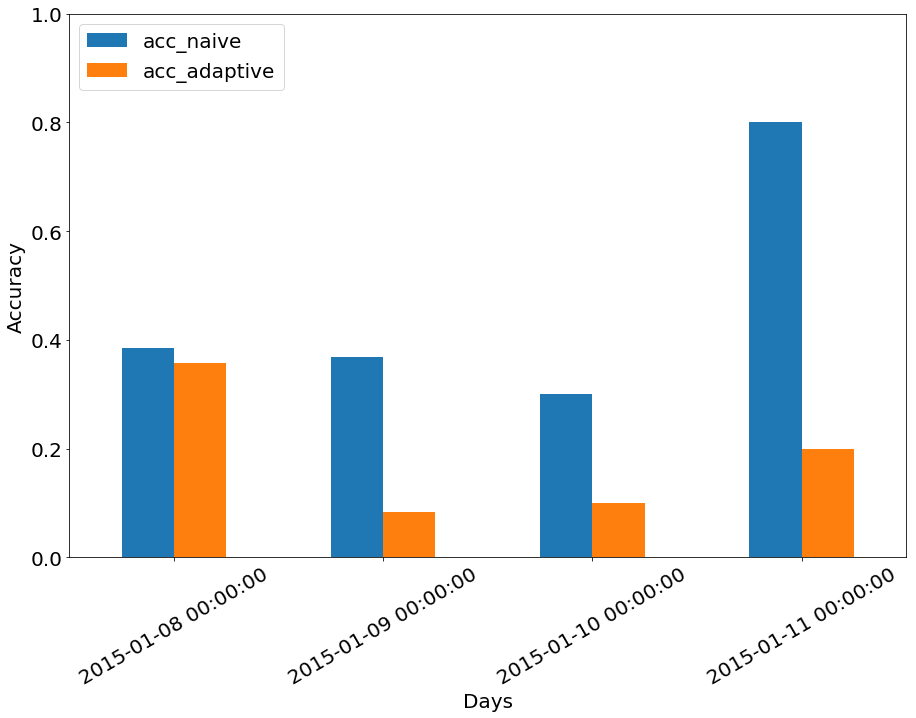

In [13]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
results.plot.bar(ax=ax, x='dates', rot=30, fontsize=fS, legend=True);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=2);
ax.set_xlabel('Days', fontsize=fS);
ax.set_ylabel('Accuracy', fontsize=fS);

In [14]:
str(dates[0])[:10]

'2015-01-07'

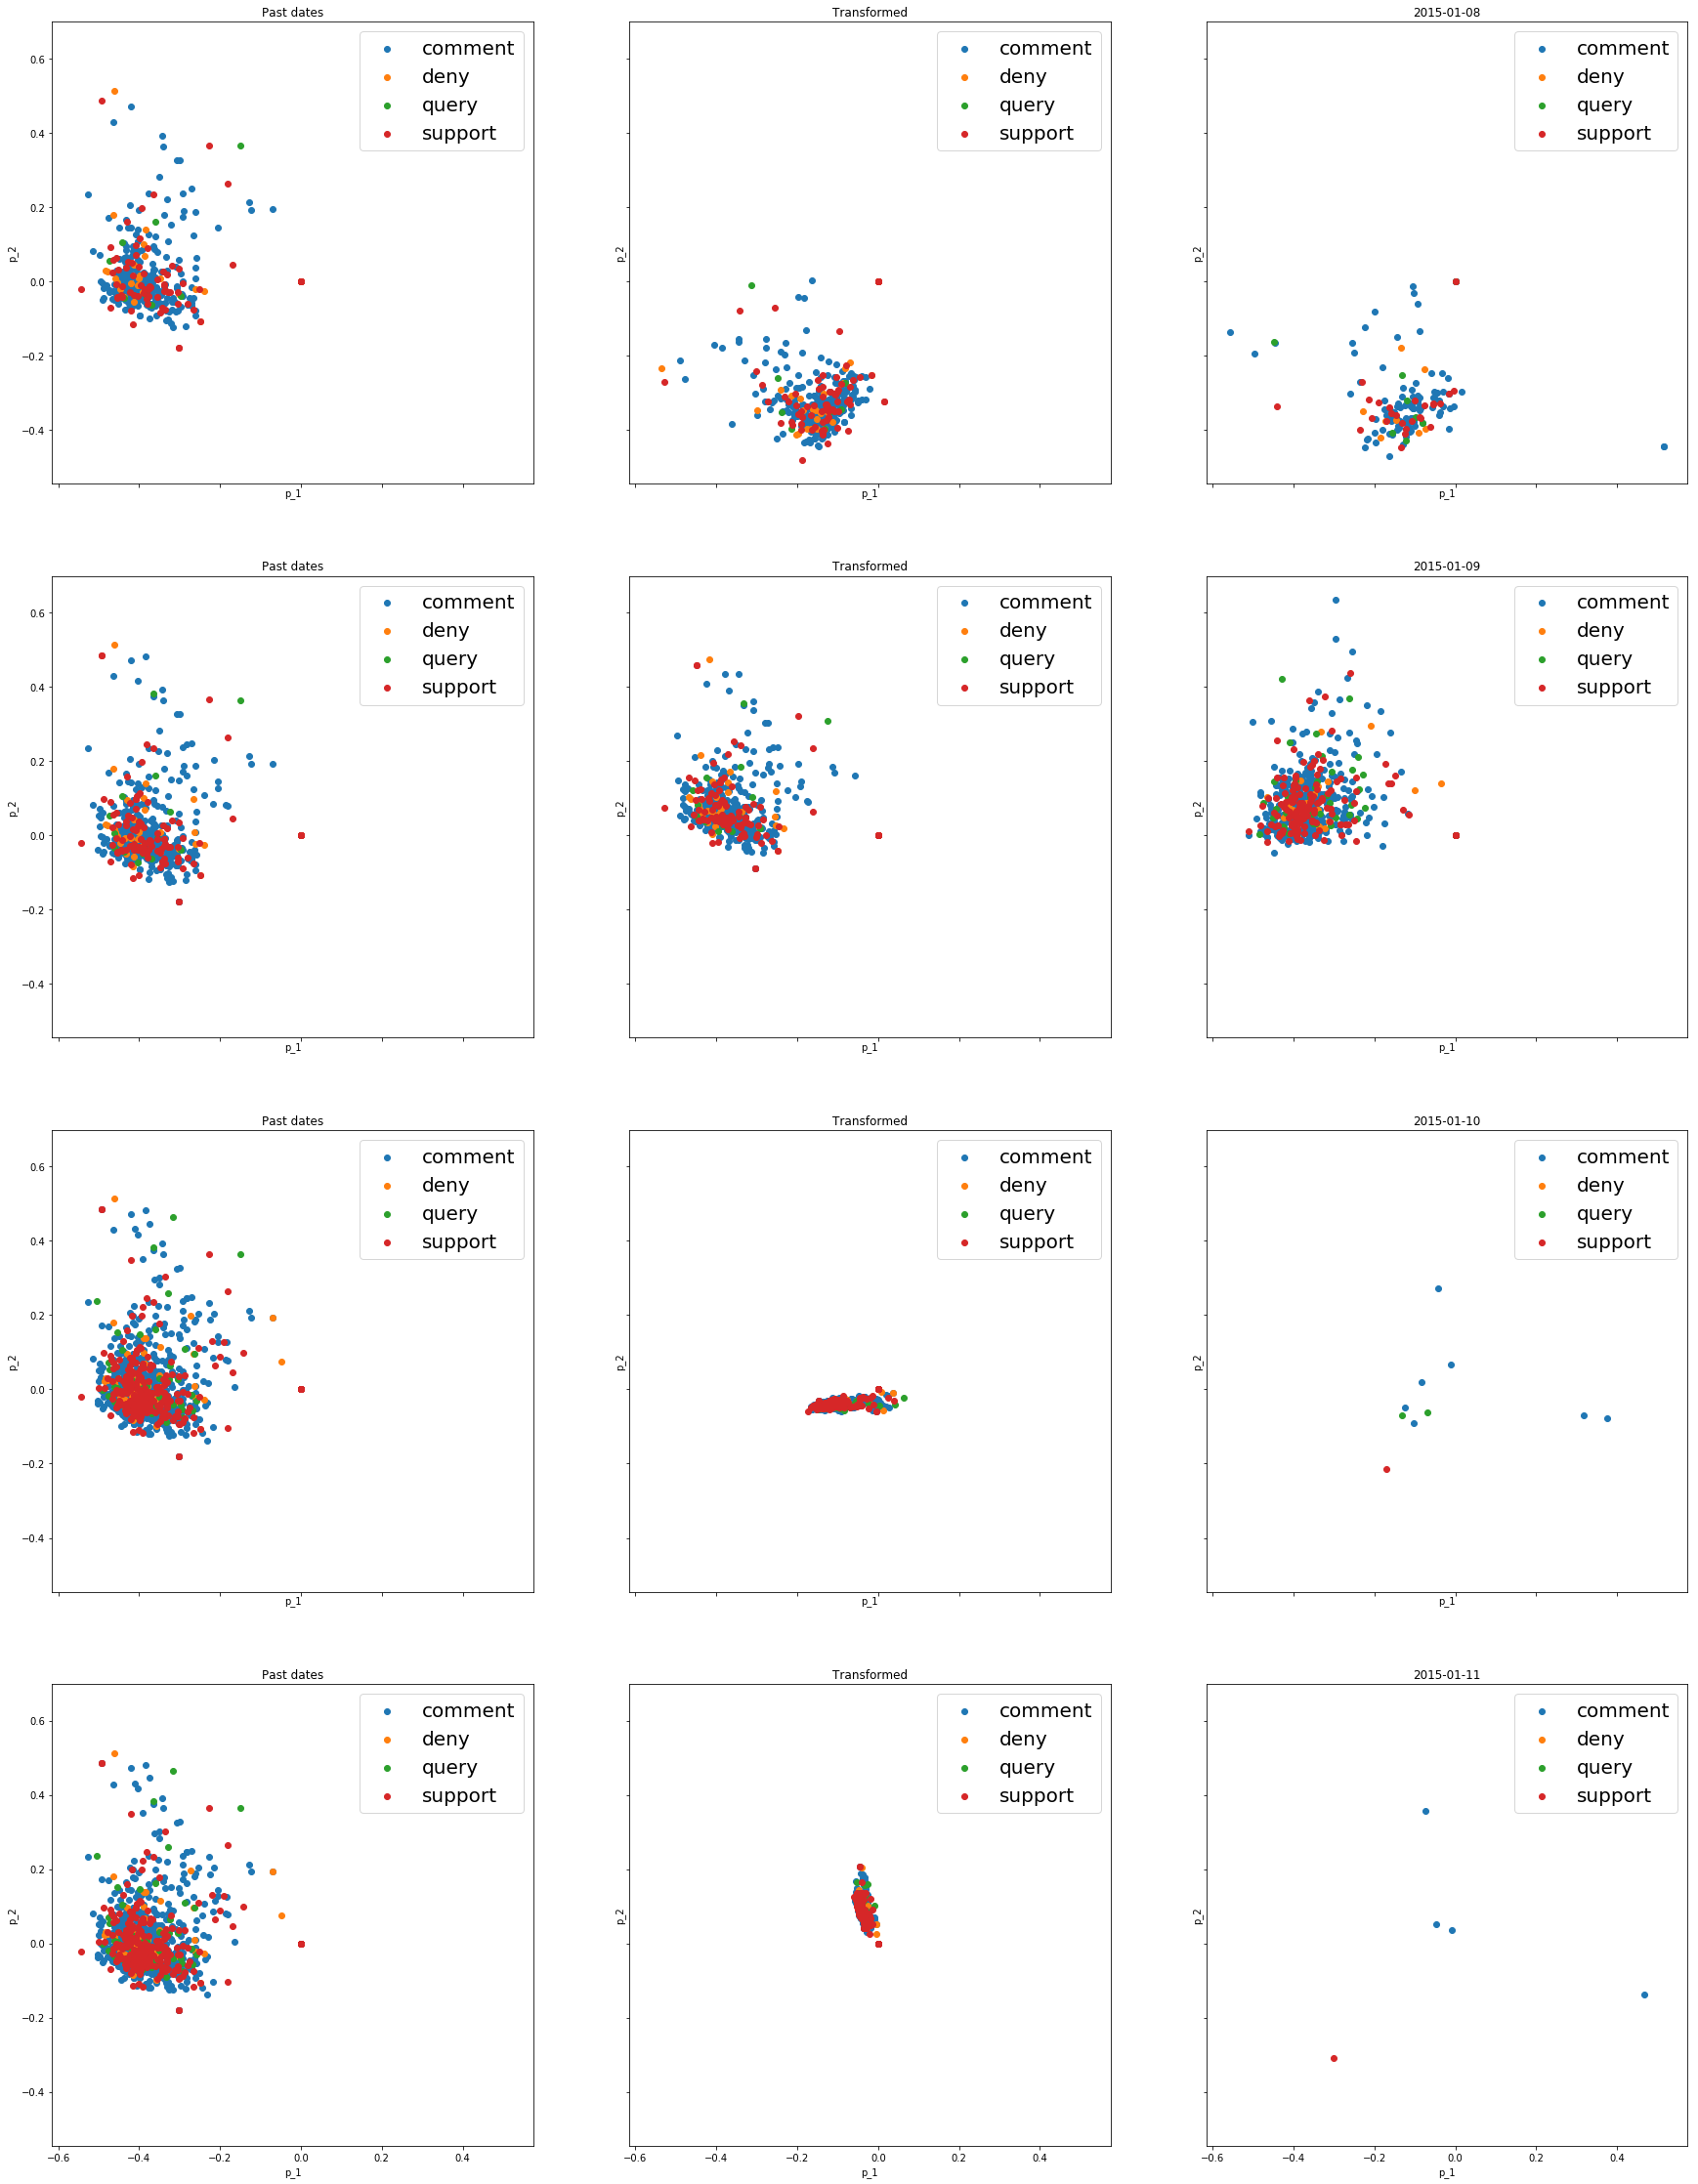

In [15]:
# Initialize figure
fig, ax = plt.subplots(nrows=len(dates)-2, ncols=3, sharex=True, sharey=True, figsize=(30, 40))

# Loop over days
for d, date in enumerate(dates[:-1]):
    
    if d == 0:
        continue
    
    # Set range up to yesterday
    past = range(d)

    # Create training data from all previous days
    trn_index = tweets_r['date'].isin(dates[past]).values

    # Find all tweets from today
    tst_index = (tweets_r['date'] == dates[d]).values.tolist()
  
    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Find subspace
    clf = SubspaceAlignedClassifier(num_components=2)
    V, CX, CZ = clf.subspace_alignment(trn_X_, tst_X, num_components=2)
    
    # Map data onto components
    X_ = trn_X @ CX 
    Z_ = tst_X @ CZ
    
    # Transformed X
    XV = X_ @ V
    
    for l, label in enumerate(labels):

        ax[d-1][0].scatter(X_[(trn_Y == l), 0], X_[(trn_Y == l), 1], label=label)
        ax[d-1][0].set_title('Past dates')
        ax[d-1][0].set_xlabel('p_1')
        ax[d-1][0].set_ylabel('p_2')
        ax[d-1][0].legend(fontsize=fS)
        
        ax[d-1][1].scatter(XV[(trn_Y == l), 0], XV[(trn_Y == l), 1], label=label)
        ax[d-1][1].set_title('Transformed')
        ax[d-1][1].set_xlabel('p_1')
        ax[d-1][1].set_ylabel('p_2')
        ax[d-1][1].legend(fontsize=fS)
        
        ax[d-1][2].scatter(Z_[(tst_Y == l), 0], Z_[(tst_Y == l), 1], label=label)
        ax[d-1][2].set_title(str(date)[:10])
        ax[d-1][2].set_xlabel('p_1')
        ax[d-1][2].set_ylabel('p_2')
        ax[d-1][2].legend(fontsize=fS)
    
plt.savefig('exp-stance_rumEval19_subalign_days-charliehebdo.png', bbox_inches=None, padding='tight')    
plt.show()

## Sequential prediction over rumours

In [16]:
# Load data
X = np.load('../data/RumEval2019/rumeval19.npy')
tweets = pd.read_json('../data/RumEval2019/RumEval19.json')

X[np.isnan(X)] = 0

In [17]:
# Subselect labels and map to numerical
labels_ = tweets['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])

In [18]:
tweets = tweets.sort_values(by=['date'])

In [19]:
dates_ = tweets['date'].values
dates = np.unique(tweets['date'].values)
sortix = np.argsort(dates_)

['ferguson',
 'ebola-essien',
 'ottawashooting',
 'prince-toronto',
 'sydneysiege',
 'charliehebdo',
 'putinmissing',
 'germanwings-crash',
 'illary']

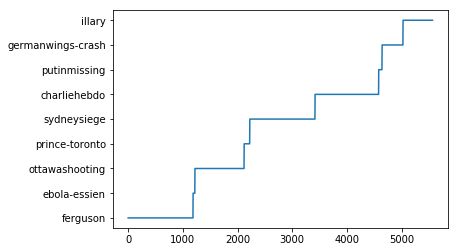

In [20]:
rumours_ = tweets['rumour'].values[sortix]
indexes = np.unique(rumours_, return_index=True)[1]
rumours = [rumours_[index] for index in sorted(indexes)]

plt.plot(rumours_)
rumours

In [21]:
# Sort embedding
X = X[sortix, :]

In [22]:
# Preallocate performance array
nperf_array = []
aperf_array = []


# Start looping over rumours
for r in range(1, len(rumours)-1):
    
    print('At rumour ' + rumours[r])
    
    # Set range up to yesterday
    past = slice(0,r)

    # Create training data from all previous days
    trn_index = tweets['rumour'].isin(rumours[past]).values

    # Find all tweets from today
    tst_index = (tweets['rumour'] == rumours[r]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Check label proportions
    print('Label shape of train set, before resampling: \t %s' % Counter(trn_Y))
    
    # Set up under-sampling using specified classifier
    trn_X_, trn_Y_ = SMOTEENN().fit_resample(trn_X, trn_Y)
    
    # Check label proportions
    print('Label shape of train set, after resampling: \t %s' % Counter(trn_Y_))
    
    # Adaptive classifier
    aclf = SubspaceAlignedClassifier(num_components=subspace_dim)
    V, CX, CZ = aclf.subspace_alignment(trn_X, tst_X)
    
    # Define classifier
    if classifier in ('lr', 'logr', 'logistic'):
        
        # Linear logistic model
        nclf = linear_model.LogisticRegression(C=l2, solver='lbfgs')
        aclf = linear_model.LogisticRegression(C=l2, solver='lbfgs')
        
    elif classifier in ('svm', 'svc', 'rbfsvc'):
        
        # Polynomial support vector machine
        nclf = svm.SVC(kernel=kernel, C=l2)
        aclf = svm.SVC(kernel=kernel, C=l2)
        
    else:
        raise ValueError('Classifier not recognized')

    # Train classifier on labeled data from previous days and unlabeled data from today
    nclf.fit(trn_X_, trn_Y_)
    aclf.fit(trn_X_ @ CX @ V, trn_Y_)

    # Make predictions on test set
    npreds = nclf.predict(tst_X)
    apreds = aclf.predict(tst_X @ CZ)

    # Test on data from current day and store
    nperf_array.append(np.mean(npreds == tst_Y))
    aperf_array.append(np.mean(apreds == tst_Y))

# Compact to DataFrame
rum_results = pd.DataFrame({'rumours': rumours[1:8],
                            'acc_naive': nperf_array,
                            'acc_adaptive': aperf_array},
                           columns=['rumours', 'acc_naive', 'acc_adaptive'])    

At rumour ebola-essien
Label shape of train set, before resampling: 	 Counter({0: 735, 3: 250, 2: 124, 1: 77})
Label shape of train set, after resampling: 	 Counter({2: 678, 1: 669, 3: 509, 0: 41})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


At rumour ottawashooting
Label shape of train set, before resampling: 	 Counter({0: 760, 3: 254, 2: 124, 1: 82})
Label shape of train set, after resampling: 	 Counter({1: 691, 2: 685, 3: 531, 0: 46})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


At rumour prince-toronto
Label shape of train set, before resampling: 	 Counter({0: 1338, 3: 430, 2: 187, 1: 165})
Label shape of train set, after resampling: 	 Counter({1: 1264, 2: 1254, 3: 964, 0: 73})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


At rumour sydneysiege
Label shape of train set, before resampling: 	 Counter({0: 1398, 3: 448, 2: 198, 1: 179})
Label shape of train set, after resampling: 	 Counter({1: 1322, 2: 1318, 3: 1030, 0: 72})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


At rumour charliehebdo
Label shape of train set, before resampling: 	 Counter({0: 2166, 3: 682, 2: 318, 1: 251})
Label shape of train set, after resampling: 	 Counter({1: 2034, 2: 2022, 3: 1685, 0: 115})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


At rumour putinmissing
Label shape of train set, before resampling: 	 Counter({0: 2960, 3: 879, 2: 408, 1: 334})
Label shape of train set, after resampling: 	 Counter({1: 2819, 2: 2794, 3: 2346, 0: 150})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


At rumour germanwings-crash
Label shape of train set, before resampling: 	 Counter({0: 3001, 3: 883, 2: 412, 1: 347})
Label shape of train set, after resampling: 	 Counter({1: 2847, 2: 2839, 3: 2369, 0: 139})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


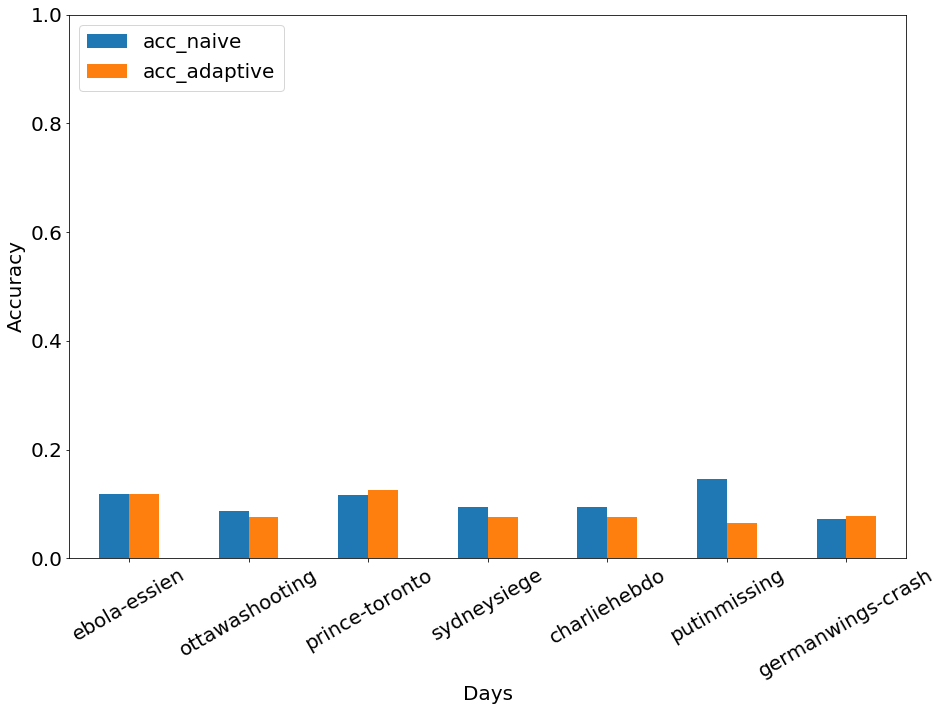

In [23]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
rum_results.plot.bar(ax=ax, x='rumours', rot=30, fontsize=fS, legend=True);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=2);
ax.set_xlabel('Days', fontsize=fS);
ax.set_ylabel('Accuracy', fontsize=fS);

At rumour ebola-essien
At rumour ottawashooting
At rumour prince-toronto
At rumour sydneysiege
At rumour charliehebdo
At rumour putinmissing
At rumour germanwings-crash


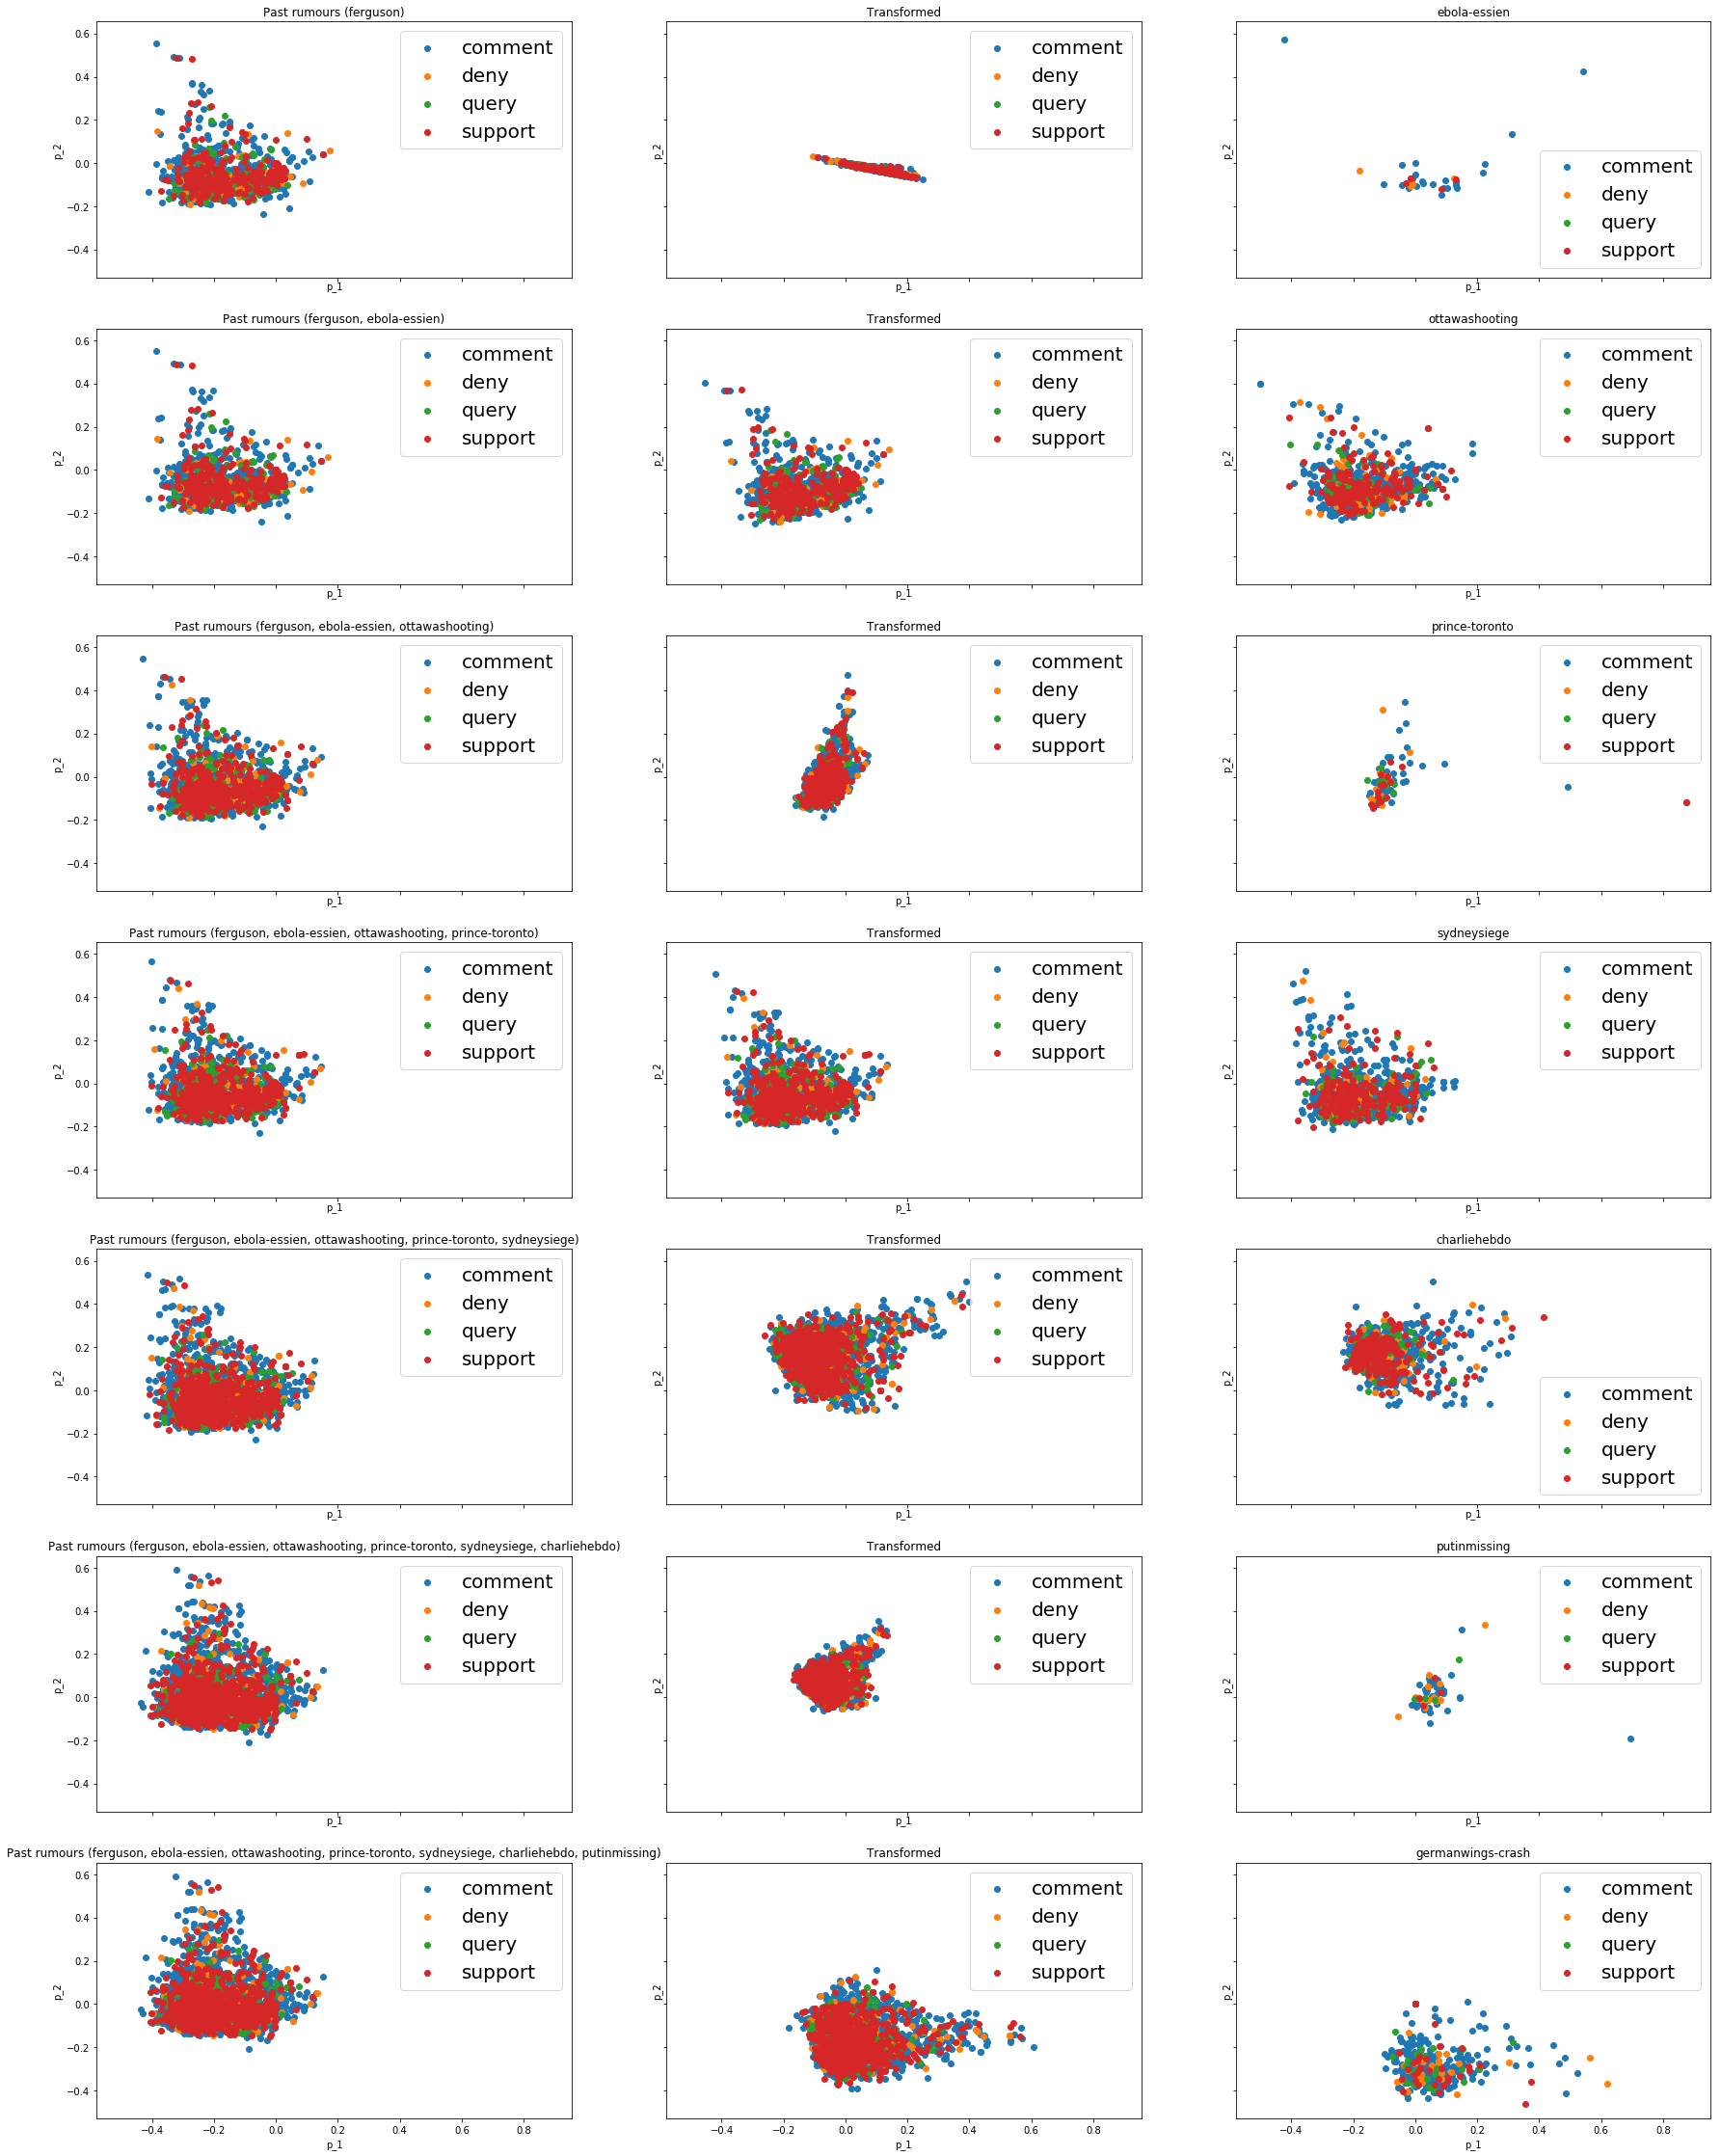

In [24]:
# Initialize figure
fig, ax = plt.subplots(nrows=len(rumours)-2, ncols=3, sharex=True, sharey=True, figsize=(30, 40))


# Start looping over rumours
for r in range(1, len(rumours)-1):
    
    print('At rumour ' + rumours[r])
    
    # Set range up to yesterday
    past = slice(0,r)

    # Create training data from all previous days
    trn_index = tweets['rumour'].isin(rumours[past]).values

    # Find all tweets from today
    tst_index = (tweets['rumour'] == rumours[r]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Find subspace
    clf = SubspaceAlignedClassifier(num_components=2)
    V, CX, CZ = clf.subspace_alignment(trn_X, tst_X, num_components=2)
    
    # Map data onto components
    X_ = trn_X @ CX
    Z_ = tst_X @ CZ
    
    # Transformed X
    XV = X_ @ V
    
    for l, label in enumerate(labels):

        ax[r-1][0].scatter(X_[(trn_Y == l), 0], X_[(trn_Y == l), 1], label=label)
        ax[r-1][0].set_title('Past rumours (' + ', '.join(rumours[past]) + ')')
        ax[r-1][0].set_xlabel('p_1')
        ax[r-1][0].set_ylabel('p_2')
        ax[r-1][0].legend(fontsize=fS)
        
        ax[r-1][1].scatter(XV[(trn_Y == l), 0], XV[(trn_Y == l), 1], label=label)
        ax[r-1][1].set_title('Transformed')
        ax[r-1][1].set_xlabel('p_1')
        ax[r-1][1].set_ylabel('p_2')
        ax[r-1][1].legend(fontsize=fS)
        
        ax[r-1][2].scatter(Z_[(tst_Y == l), 0], Z_[(tst_Y == l), 1], label=label)
        ax[r-1][2].set_title(rumours[r])
        ax[r-1][2].set_xlabel('p_1')
        ax[r-1][2].set_ylabel('p_2')
        ax[r-1][2].legend(fontsize=fS)
    
plt.savefig('exp-stance_rumEval19_subalign_rumours.png', bbox_inches=None, padding='tight')    
plt.show()